<a href="https://colab.research.google.com/github/Prakartt/Customer-Segmentation-and-Stock-market-prediction-for-portfolio-generation-/blob/main/LSTM_model_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h2>PART 1. Data Pre-processing</h2>

In [ ]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import statsmodels.api as sm

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import TensorBoard
from  tensorflow.keras.callbacks import ReduceLROnPlateau
from  tensorflow.keras.callbacks import EarlyStopping

<h3>Step #1. Read data</h3>

In [ ]:
# Importing Training Set
dataset_train = pd.read_csv('AAPL.csv')

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (10473, 7)
All timestamps == 10473
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [ ]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (10473, 5).


array([[1.28348000e-01, 1.28906000e-01, 1.28348000e-01, 1.28348000e-01,
        1.00178000e-01],
       [1.22210000e-01, 1.22210000e-01, 1.21652000e-01, 1.21652000e-01,
        9.49520000e-02],
       [1.13281000e-01, 1.13281000e-01, 1.12723000e-01, 1.12723000e-01,
        8.79830000e-02],
       ...,
       [1.36820007e+02, 1.38589996e+02, 1.35630005e+02, 1.38270004e+02,
        1.38270004e+02],
       [1.39899994e+02, 1.41910004e+02, 1.39770004e+02, 1.41660004e+02,
        1.41660004e+02],
       [1.42699997e+02, 1.43490005e+02, 1.40970001e+02, 1.41660004e+02,
        1.41660004e+02]])

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.45875509],
       [-0.4589468 ],
       [-0.45922567],
       ...,
       [ 3.81050707],
       [ 3.90670366],
       [ 3.99415557]])

In [ ]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 725   # Number of days we want top predict into the future
n_past = 600     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (9149, 600, 4).
y_train shape == (9149, 1).


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [ ]:
# Import Libraries and packages from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='relu'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.03), loss='mean_squared_error')


AttributeError: ignored

In [ ]:

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

y_pred_prob = model.predict(test_X, verbose=0)
y_pred_prob = y_pred_prob[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), PREDC)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), y_pred_prob)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), y_pred_prob)
print('Max Error: %f' % var2)

<h3>Step #4. Start training</h3>

In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 0.1568
Epoch 1: val_loss improved from inf to 3.29888, saving model to weights.h5
29/29 [==============================] - 45s 1s/step - loss: 0.1568 - val_loss: 3.2989 - lr: 0.0100
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.1557
Epoch 2: val_loss improved from 3.29888 to 3.19113, saving model to weights.h5
29/29 [==============================] - 32s 1s/step - loss: 0.1557 - val_loss: 3.1911 - lr: 0.0100
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.1556
Epoch 3: val_loss did not improve from 3.19113
29/29 [==============================] - 32s 1s/step - loss: 0.1556 - val_loss: 3.2739 - lr: 0.0100
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.1555
Epoch 4: val_loss did not improve from 3.19113
29/29 [==============================] - 33s 1s/step - loss: 0.1555 - val_loss: 3.4307 - lr: 0.0100
Epoch 5/30
29/29 [==============================] - 

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

<h3>Step #5. Make predictions for future dates</h3>

In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

#y_pred_prob = model.predict(test_X, verbose=0)
# y_pred_prob = y_pred_prob[:, 0]

var = explained_variance_score(dataset_train.iloc[:8549,1], predictions_train)
print('Variance: %f' % var)

r2 = r2_score(dataset_train.iloc[:8549,1], predictions_train)
print('R2 Score: %f' % var)

# var2 = max_error(test_Y.reshape(-1,1), y_pred_prob)
# print('Max Error: %f' % var2)

Variance: 0.055231
R2 Score: 0.055231


In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN['Open']=PREDICTION_TRAIN['Open']
PREDICTIONS_FUTURE['Open']=PREDICTIONS_FUTURE['Open']+1151

PREDICTIONS_FUTURE[:3]

,Open
2022-06-27,1181.764526
2022-06-28,1181.765747
2022-06-29,1181.760010


<h3>Step #6. Visualize the Predictions</h3>

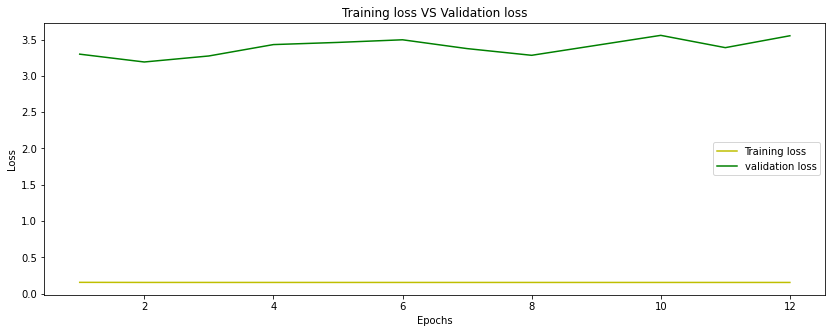

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,13)
plt.plot(epochs, loss_train, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='validation loss')
plt.title('Training loss VS Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 725 entries, 2022-06-27 to 2024-06-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    725 non-null    float32
dtypes: float32(1)
memory usage: 8.5 KB


KeyError: ignored

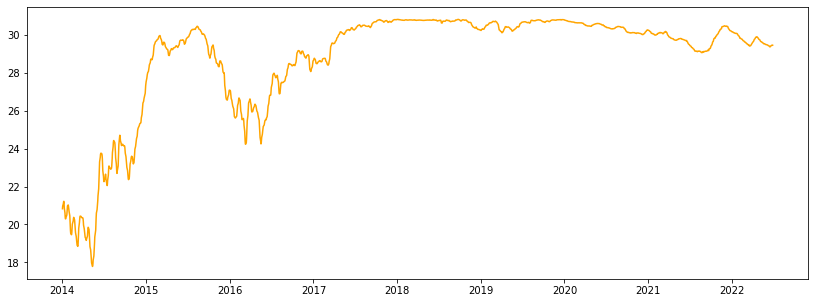

In [ ]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5


PREDICTIONS_FUTURE.info()

# Plot parameters
START_DATE_FOR_PLOTTING = '2014-01-01'

#plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
#plt.plot(DFval['Date'],DFval['Open'])
#plt.plot(df['Date'],df['Close'])
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')

plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:]['Date'], dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)

plt.show()

In [ ]:
plt.plot(DFval.index,DFval['Open'])


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)